<a href="https://colab.research.google.com/github/mateuszrusin/ml-filmweb-score/blob/master/Analiza_fanych_filmweb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

## Pobieranie danych

Dane z repozytorium github, filmy ocenione na filmwebie

In [2]:
!wget -O oceny.csv https://raw.githubusercontent.com/mateuszrusin/ml-filmweb-score/master/oceny.csv

--2019-11-10 23:04:53--  https://raw.githubusercontent.com/mateuszrusin/ml-filmweb-score/master/oceny.csv
Translacja raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Łączenie się z raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 97619 (95K) [text/plain]
Zapis do: `oceny.csv'

oceny.csv           100%[===================>]  95,33K  --.-KB/s     w 0,06s   

2019-11-10 23:04:54 (1,49 MB/s) - zapisano `oceny.csv' [97619/97619]



Baza danych imdb ze strony https://www.imdb.com/interfaces/

In [3]:
!wget https://datasets.imdbws.com/title.basics.tsv.gz
!wget https://datasets.imdbws.com/title.ratings.tsv.gz

--2019-11-10 23:04:54--  https://datasets.imdbws.com/title.basics.tsv.gz
Translacja datasets.imdbws.com (datasets.imdbws.com)... 54.230.229.32, 54.230.229.83, 54.230.229.85, ...
Łączenie się z datasets.imdbws.com (datasets.imdbws.com)|54.230.229.32|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 112447878 (107M) [binary/octet-stream]
Zapis do: `title.basics.tsv.gz'

title.basics.tsv.gz 100%[===================>] 107,24M  28,7MB/s     w 4,6s    

2019-11-10 23:04:59 (23,2 MB/s) - zapisano `title.basics.tsv.gz' [112447878/112447878]

--2019-11-10 23:04:59--  https://datasets.imdbws.com/title.ratings.tsv.gz
Translacja datasets.imdbws.com (datasets.imdbws.com)... 54.230.229.83, 54.230.229.85, 54.230.229.32, ...
Łączenie się z datasets.imdbws.com (datasets.imdbws.com)|54.230.229.83|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 4887935 (4,7M) [binary/octet-stream]
Zapis do: `title.ratings.tsv.gz'

title.ratings.tsv.g

### Rozpakowywanie

In [4]:
!gzip -d -f title.basics.tsv.gz
!gzip -d -f title.ratings.tsv.gz

### Pobieranie do DataFrame

In [5]:
oceny = pd.read_csv('oceny.csv')
oceny.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 10 columns):
ID                  1192 non-null int64
Tytuł polski        1192 non-null object
Tytuł oryginalny    904 non-null object
Rok produkcji       1192 non-null int64
Ulubione            3 non-null object
Ocena               1192 non-null object
Komentarz           0 non-null float64
Kraj produkcji      1192 non-null object
Gatunek             1192 non-null object
Data                1192 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 93.2+ KB


otwarcie danych `.tsv` do pliku

In [6]:
imdb_title = pd.read_csv('title.basics.tsv', sep='\t')
imdb_title.tail()

/home/me/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
6300819,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,\N,\N,"Action,Drama,Family"
6300820,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
6300821,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
6300822,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short
6300823,tt9916880,tvEpisode,Horrid Henry Knows It All,Horrid Henry Knows It All,0,2014,\N,10,"Animation,Comedy,Family"


Otwarcie danych z ocenami w imdb

In [7]:
imdb_raiting = pd.read_csv('title.ratings.tsv', sep='\t')
imdb_raiting.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1546
1,tt0000002,6.1,187
2,tt0000003,6.5,1204
3,tt0000004,6.2,114
4,tt0000005,6.1,1931


Połączenie danych ocen i filmu

In [8]:
imdb = pd.merge(imdb_title, imdb_raiting, how='left',on='tconst')
imdb.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.6,1546.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.1,187.0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1204.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short",6.2,114.0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.1,1931.0


Przykład filmu o tym samym tytule i tym samym roku.

In [9]:
imdb[(imdb['originalTitle'] == 'Joker') & (imdb['startYear'] == '2019')]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
1286554,tt10556334,movie,Joker,Joker,0,2019,\N,92,Documentary,NaN,NaN
1548312,tt11010430,tvEpisode,Joker,Joker,0,2019,\N,\N,Talk-Show,6.8,6.0
1574436,tt11055460,tvEpisode,Joker,Joker,0,2019,\N,12,"Comedy,Talk-Show",7.4,7.0
1581561,tt11067740,tvEpisode,Joker,Joker,0,2019,\N,\N,"Comedy,Talk-Show",NaN,NaN
1581565,tt11067748,tvEpisode,Joker,Joker,0,2019,\N,\N,Talk-Show,NaN,NaN
1581581,tt11067776,tvEpisode,Joker,Joker,0,2019,\N,\N,Talk-Show,NaN,NaN
1583206,tt11070632,tvEpisode,Joker,Joker,0,2019,\N,\N,Talk-Show,NaN,NaN
1583413,tt11070984,tvEpisode,Joker,Joker,0,2019,\N,\N,Comedy,NaN,NaN
1584412,tt11072680,tvEpisode,Joker,Joker,0,2019,\N,\N,Comedy,NaN,NaN
1592065,tt11086026,tvEpisode,Joker,Joker,0,2019,\N,28,"Comedy,Talk-Show",7.4,11.0


## KONWERSJA kolumn

Zamiana tekstu na listę kategorii, zaś te na nowe kolumny o wartościach binarnych:

In [10]:
def to_list(textdata):
    return "".join(textdata.lower().split()).split(',')

def multibinarize(series):
    mlb = MultiLabelBinarizer()
    data = pd.DataFrame(mlb.fit_transform(series.apply(to_list)), columns=mlb.classes_, index=df.index)
    return mlb.classes_, data

def dummies(series):
    data = pd.get_dummies(series.apply(to_list).apply(pd.Series).stack()).sum(level=0)
    return data

df = oceny.drop(columns=['Komentarz'])
df = df[df.Ocena != 'brak oceny']

# multibinarize
kraj_classes, kraj_data = multibinarize(df['Kraj produkcji'])
df[kraj_classes] = kraj_data

# get_dummies
gatunki = dummies(df['Gatunek'])

df = pd.concat(
    [
        df,
        gatunki
    ], axis=1
)
df

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ulubione,Ocena,Kraj produkcji,Gatunek,Data,arabiasaudyjska,...,religijny,romans,sci-fi,sensacyjny,sportowy,surrealistyczny,szpiegowski,thriller,western,wojenny
0,810167,Joker,NaN,2019,NaN,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,0,0,0,0,0,0,0,0,0,0
1,796158,"Podły, okrutny, zły","Extremely Wicked, Shockingly Evil and Vile",2019,NaN,6,USA,"Biograficzny, Kryminał, Thriller",2019-10-6,0,...,0,0,0,0,0,0,0,1,0,0
2,753119,Prosta historia o morderstwie,NaN,2016,NaN,3,Polska,"Kryminał, Thriller",2019-10-5,0,...,0,0,0,0,0,0,0,1,0,0
3,797600,"Ciemno, prawie noc",NaN,2019,NaN,2,Polska,"Kryminał, Thriller",2019-10-5,0,...,0,0,0,0,0,0,0,1,0,0
4,460220,Wyznania zakupoholiczki,Confessions of a Shopaholic,2009,NaN,3,USA,Komedia rom.,2019-10-4,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,9509,Shrek,NaN,2001,NaN,6,USA,"Animacja, Familijny, Komedia",2011-8-4,0,...,0,0,0,0,0,0,0,0,0,0
1188,837,Podziemny krąg,Fight Club,1999,NaN,7,"Niemcy, USA","Thriller, Psychologiczny",2011-8-4,0,...,0,0,0,0,0,0,0,1,0,0
1189,936,Gladiator,NaN,2000,NaN,4,"USA, Wielka Brytania",Dramat historyczny,2011-8-4,0,...,0,0,0,0,0,0,0,0,0,0
1190,9136,Requiem dla snu,Requiem for a Dream,2000,NaN,7,USA,Dramat,2011-8-4,0,...,0,0,0,0,0,0,0,0,0,0


Uzupełnianie i zakodowanie danych binarnych oraz liczbowych 

In [11]:
def label_encode(series):
    encoder = LabelEncoder()
    encoder.fit(series)
    return encoder.transform(series)    

df['Ulubione'] = label_encode(df.Ulubione.fillna(''))
df['Ocena'] = df.Ocena.astype(int)

Pobranie nowych danych z API Filmweb

In [12]:
def movie_info(id):
    try:
        film = Film.get_by_id(id)
        film.populate()
        return film.budget, film.boxoffice, film.topics_count
    except Exception:
        return None, None, None

# warning - takes long time (a lot filmweb api calls)
# new_columns = ['budget', 'boxoffice', 'topics_count']
# df[new_columns] = df.apply(lambda x: movie_info(x.ID), axis=1, result_type='expand')
# df[new_columns] = df[new_columns].apply(lambda x: x.fillna(x.mean()), axis=0).astype(int)

df = pd.concat(
    [
        df.reset_index(drop=True),
        pd.read_csv('oceny_scraped.csv')
    ], axis=1
)

Uzupełnienie brakujących danych za pomocą średnich wobec wyliczonych 5 grup

In [ ]:
df.topics_count = df.topics_count.fillna(0).astype(int)

def make_groups(df):
    minidf = df.drop(columns=['budget', 'boxoffice', 'ID', 'Gatunek', 'Kraj produkcji', 'Tytuł polski', 'Tytuł oryginalny', 'Data', 'Ulubione'])
    kmeans = KMeans(n_jobs=-1, n_clusters=5)
    kmeans.fit(minidf)
    return kmeans.predict(minidf)

def fill_mean(column):
    return df.groupby('group')[column].apply(lambda x: x.fillna(x.mean())).astype(int)

df['group'] = make_groups(df)        
df['budget'] = fill_mean('budget')
df['boxoffice'] = fill_mean('boxoffice')

Do połączenia `pd.merge` wymagane są kolumny o tych samych nazwach i typach, dlatego rok konwertujemy na tekst.

In [13]:
oceny['originalTitle'] = oceny['Tytuł oryginalny']
oceny['startYear'] = oceny['Rok produkcji'].astype(str)

oceny.head()

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ulubione,Ocena,Kraj produkcji,Gatunek,Data,arabiasaudyjska,...,surrealistyczny,szpiegowski,thriller,western,wojenny,budget,boxoffice,topics_count,originalTitle,startYear
0,810167,Joker,NaN,2019,0,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,0,0,0,0,0,55000000,852031557,593,NaN,2019
1,796158,"Podły, okrutny, zły","Extremely Wicked, Shockingly Evil and Vile",2019,0,6,USA,"Biograficzny, Kryminał, Thriller",2019-10-6,0,...,0,0,1,0,0,34210862,82286993,89,"Extremely Wicked, Shockingly Evil and Vile",2019
2,753119,Prosta historia o morderstwie,NaN,2016,0,3,Polska,"Kryminał, Thriller",2019-10-5,0,...,0,0,1,0,0,34210862,82286993,58,NaN,2016
3,797600,"Ciemno, prawie noc",NaN,2019,0,2,Polska,"Kryminał, Thriller",2019-10-5,0,...,0,0,1,0,0,34210862,82286993,137,NaN,2019
4,460220,Wyznania zakupoholiczki,Confessions of a Shopaholic,2009,0,3,USA,Komedia rom.,2019-10-4,0,...,0,0,0,0,0,34210862,108333222,215,Confessions of a Shopaholic,2009


Dla pustych wartości `originalTitle` dodajemy tytuł polski


In [14]:
oceny['originalTitle'] = oceny['originalTitle'].fillna(oceny['Tytuł polski'])
oceny.head()

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ulubione,Ocena,Kraj produkcji,Gatunek,Data,arabiasaudyjska,...,surrealistyczny,szpiegowski,thriller,western,wojenny,budget,boxoffice,topics_count,originalTitle,startYear
0,810167,Joker,NaN,2019,0,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,0,0,0,0,0,55000000,852031557,593,Joker,2019
1,796158,"Podły, okrutny, zły","Extremely Wicked, Shockingly Evil and Vile",2019,0,6,USA,"Biograficzny, Kryminał, Thriller",2019-10-6,0,...,0,0,1,0,0,34210862,82286993,89,"Extremely Wicked, Shockingly Evil and Vile",2019
2,753119,Prosta historia o morderstwie,NaN,2016,0,3,Polska,"Kryminał, Thriller",2019-10-5,0,...,0,0,1,0,0,34210862,82286993,58,Prosta historia o morderstwie,2016
3,797600,"Ciemno, prawie noc",NaN,2019,0,2,Polska,"Kryminał, Thriller",2019-10-5,0,...,0,0,1,0,0,34210862,82286993,137,"Ciemno, prawie noc",2019
4,460220,Wyznania zakupoholiczki,Confessions of a Shopaholic,2009,0,3,USA,Komedia rom.,2019-10-4,0,...,0,0,0,0,0,34210862,108333222,215,Confessions of a Shopaholic,2009


Tłumaczymy kategorię, tak że kategoria po polsku z `filmweb` jest kategorią z imdb

In [15]:
match = {
    'akcja': 'action',
    'dramat': 'drama',
    'animowany': 'cartoon',
    'romans': 'romance',
    'drogi': 'road',
    'biograficzny': 'biographic',
    'romantyczny': 'romantic',
    'wojenny': 'war',
    'katastroficzny': 'disaster',
    'kryminał': 'crime',
    'komedia': 'comedy',
    'dokumentalny': 'documentary',
    'pełnometrażowy': 'full-length',
    'krótkometrażowy': 'short',
    'niemy': 'silent',
    'historyczny': 'historical',
    'edukacyjny': 'educational',
    'kostiumowy': 'costume',
    'obyczajowy': 'drama'
}


def change_type(t):
  arr = [match[s.lower()] if s.lower() in match else s.lower() for s in to_list(t)]
  return ", ".join(arr)

oceny['genre_eng'] = oceny.apply(lambda x: change_type(x['Gatunek']), axis=1)
oceny.head()

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ulubione,Ocena,Kraj produkcji,Gatunek,Data,arabiasaudyjska,...,szpiegowski,thriller,western,wojenny,budget,boxoffice,topics_count,originalTitle,startYear,genre_eng
0,810167,Joker,NaN,2019,0,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,0,0,0,0,55000000,852031557,593,Joker,2019,"drama, crime, action"
1,796158,"Podły, okrutny, zły","Extremely Wicked, Shockingly Evil and Vile",2019,0,6,USA,"Biograficzny, Kryminał, Thriller",2019-10-6,0,...,0,1,0,0,34210862,82286993,89,"Extremely Wicked, Shockingly Evil and Vile",2019,"biographic, crime, thriller"
2,753119,Prosta historia o morderstwie,NaN,2016,0,3,Polska,"Kryminał, Thriller",2019-10-5,0,...,0,1,0,0,34210862,82286993,58,Prosta historia o morderstwie,2016,"crime, thriller"
3,797600,"Ciemno, prawie noc",NaN,2019,0,2,Polska,"Kryminał, Thriller",2019-10-5,0,...,0,1,0,0,34210862,82286993,137,"Ciemno, prawie noc",2019,"crime, thriller"
4,460220,Wyznania zakupoholiczki,Confessions of a Shopaholic,2009,0,3,USA,Komedia rom.,2019-10-4,0,...,0,0,0,0,34210862,108333222,215,Confessions of a Shopaholic,2009,komediarom.


In [16]:
print(oceny.dtypes)

ID                   int64
Tytuł polski        object
Tytuł oryginalny    object
Rok produkcji        int64
Ulubione             int64
                     ...  
boxoffice            int64
topics_count         int64
originalTitle       object
startYear           object
genre_eng           object
Length: 113, dtype: object


In [17]:
oceny[(oceny['originalTitle']=='Joker') & (oceny['startYear']=='2019')]

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ulubione,Ocena,Kraj produkcji,Gatunek,Data,arabiasaudyjska,...,szpiegowski,thriller,western,wojenny,budget,boxoffice,topics_count,originalTitle,startYear,genre_eng
0,810167,Joker,NaN,2019,0,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,0,0,0,0,55000000,852031557,593,Joker,2019,"drama, crime, action"


## Połączenie z IMDB

Łączymy tylko ten tekst który w imdb, ma `titleType`==`movie`,  inaczej mogą powstać duplikaty. Łączymy po roku i oryignalnym tytule). Najpierw usuwamy z `imdb` także puste wartości rok albo originalny tytuł.

In [18]:
print(len(imdb))
imdb = imdb.dropna(subset=['startYear','originalTitle'])
imdb = imdb[imdb['titleType']=='movie']
imdb.head()

6300824


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.4,81.0
145,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport",5.1,308.0
332,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",6.1,40.0
499,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,NaN,NaN
571,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama",6.1,537.0


In [19]:
oceny_imdb = pd.merge(
    oceny,
    imdb,
    how='inner',
    on=['startYear','originalTitle'])
print(len(oceny_imdb))
oceny_imdb.head()

1120


,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ulubione,Ocena,Kraj produkcji,Gatunek,Data,arabiasaudyjska,...,genre_eng,tconst,titleType,primaryTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes
0,810167,Joker,NaN,2019,0,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,"drama, crime, action",tt10556334,movie,Joker,0,\N,92,Documentary,NaN,NaN
1,810167,Joker,NaN,2019,0,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,"drama, crime, action",tt7286456,movie,Joker,0,\N,122,"Crime,Drama,Thriller",8.8,435087.0
2,796158,"Podły, okrutny, zły","Extremely Wicked, Shockingly Evil and Vile",2019,0,6,USA,"Biograficzny, Kryminał, Thriller",2019-10-6,0,...,"biographic, crime, thriller",tt2481498,movie,"Extremely Wicked, Shockingly Evil and Vile",0,\N,110,"Biography,Crime,Drama",6.6,56935.0
3,753119,Prosta historia o morderstwie,NaN,2016,0,3,Polska,"Kryminał, Thriller",2019-10-5,0,...,"crime, thriller",tt6182864,movie,Prosta historia o morderstwie,0,\N,89,"Crime,Thriller",5.9,228.0
4,797600,"Ciemno, prawie noc",NaN,2019,0,2,Polska,"Kryminał, Thriller",2019-10-5,0,...,"crime, thriller",tt7790894,movie,"Dark, Almost Night",0,\N,114,"Crime,Drama",4.6,277.0


 Nadal znajdują się duplikaty. Ponieważ rok i tytuł nie jest jednoznaczny w IMDB

In [20]:
print('Zduplikowane: ', len(oceny_imdb[oceny_imdb.duplicated(subset=['originalTitle'])]))
oceny_imdb[oceny_imdb['originalTitle']=='Joker']

Zduplikowane:  38


,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ulubione,Ocena,Kraj produkcji,Gatunek,Data,arabiasaudyjska,...,genre_eng,tconst,titleType,primaryTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes
0,810167,Joker,NaN,2019,0,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,"drama, crime, action",tt10556334,movie,Joker,0,\N,92,Documentary,NaN,NaN
1,810167,Joker,NaN,2019,0,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,"drama, crime, action",tt7286456,movie,Joker,0,\N,122,"Crime,Drama,Thriller",8.8,435087.0


Patrzymy po gatunku i wyznaczymy jak bardzo jeden gatunek jest podobny do drugiego. Jak widać najbardziej podobny do filmu Joker, jest Ten z dwoma  identycznymi kategoriami.

In [21]:
def get_similarity(row):    
    text_list_eng = to_list(row['genre_eng'])
    text_list_genres = to_list(row['genres'])

    # product of those lists
    commons = set(text_list_eng) & set(text_list_genres)  
    
    return len(commons)

oceny_imdb['similarity'] = oceny_imdb.apply(get_similarity,axis=1)
oceny_duplicated = oceny_imdb[oceny_imdb.duplicated(subset=['originalTitle'], keep=False)]
oceny_duplicated

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ulubione,Ocena,Kraj produkcji,Gatunek,Data,arabiasaudyjska,...,tconst,titleType,primaryTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes,similarity
0,810167,Joker,NaN,2019,0,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,tt10556334,movie,Joker,0,\N,92,Documentary,NaN,NaN,0
1,810167,Joker,NaN,2019,0,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,tt7286456,movie,Joker,0,\N,122,"Crime,Drama,Thriller",8.8,435087.0,2
26,7967,Na fali,Point Break,1991,0,7,USA,Sensacyjny,2019-8-8,0,...,tt0102685,movie,Point Break,0,\N,122,"Action,Crime,Thriller",7.3,143793.0,0
45,785673,Kochanek idealny,Zoe,2018,0,4,USA,Romans,2019-5-13,0,...,tt5969746,movie,Zoe,0,\N,95,Mystery,NaN,NaN,0
46,785673,Kochanek idealny,Zoe,2018,0,4,USA,Romans,2019-5-13,0,...,tt6010628,movie,Zoe,0,\N,104,"Romance,Sci-Fi",6.1,6058.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,490841,Zeszłej nocy,Last Night,2010,0,6,"Francja, USA",Melodramat,2012-11-8,0,...,tt1294688,movie,Last Night,0,\N,93,"Drama,Romance",6.6,45207.0,0
811,490841,Zeszłej nocy,Last Night,2010,0,6,"Francja, USA",Melodramat,2012-11-8,0,...,tt1740794,movie,Last Night,0,\N,69,"Drama,Romance",NaN,NaN,0
900,619088,Zamiana,Switch,2011,0,6,Francja,"Thriller, Akcja",2012-1-9,0,...,tt1401636,movie,Switch,0,\N,104,"Action,Crime,Thriller",6.3,3097.0,2
901,619088,Zamiana,Switch,2011,0,6,Francja,"Thriller, Akcja",2012-1-9,0,...,tt2326252,movie,Switch,0,\N,80,Documentary,NaN,NaN,0


Zostawaiamy te oceny które mają najwyższe `similarity` i odrzucamy inne

In [22]:
top1 = oceny_imdb.groupby(['ID']).apply(lambda x: x.sort_values(["similarity"], ascending = False)).reset_index(drop=True)
oceny_imdb2 = top1.groupby('ID').head(1).copy()

oceny_imdb2[oceny_imdb2['originalTitle']=='Joker']

,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ulubione,Ocena,Kraj produkcji,Gatunek,Data,arabiasaudyjska,...,tconst,titleType,primaryTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes,similarity
1102,810167,Joker,NaN,2019,0,7,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0,...,tt7286456,movie,Joker,0,\N,122,"Crime,Drama,Thriller",8.8,435087.0,2


## KONWERSJA na dane liczbowe

Zmieniamy typ roku producji i oceny na typ liczbowy



In [23]:
oceny_imdb2["Rok produkcji"] =  oceny_imdb2["Rok produkcji"].astype(float)
oceny_imdb2[oceny_imdb2["Ocena"]=='brak oceny'] = np.nan
oceny_imdb2["Ocena"] = oceny_imdb2["Ocena"].astype(float)

oceny_imdb2[oceny_imdb2['originalTitle']=='Joker']

/home/me/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,ID,Tytuł polski,Tytuł oryginalny,Rok produkcji,Ulubione,Ocena,Kraj produkcji,Gatunek,Data,arabiasaudyjska,...,tconst,titleType,primaryTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes,similarity
1102,810167.0,Joker,NaN,2019.0,0.0,7.0,"Kanada, USA","Dramat, Kryminał, Akcja",2019-10-11,0.0,...,tt7286456,movie,Joker,0.0,\N,122,"Crime,Drama,Thriller",8.8,435087.0,2.0


Zapisanie average rating wartości zero.

In [24]:
#oceny_imdb[oceny_imdb["averageRating"]=='-unknow-'] = '0'
oceny_imdb2[['averageRating']] = oceny_imdb2[['averageRating']].fillna(value=0)
oceny_imdb2[['averageRating_int']]  = oceny_imdb2[['averageRating']].round().astype(int)

print(oceny_imdb2[['averageRating_int']].dtypes)

averageRating_int    int64
dtype: object


Sprawdzenie jakie wartości może przyjmować

In [25]:
oceny_imdb2['averageRating_int'].unique()

array([8, 7, 6, 9, 4, 5, 3])

## PLOT

https://python-graph-gallery.com/

## SEABORN

https://python-graph-gallery.com/41-control-marker-features/

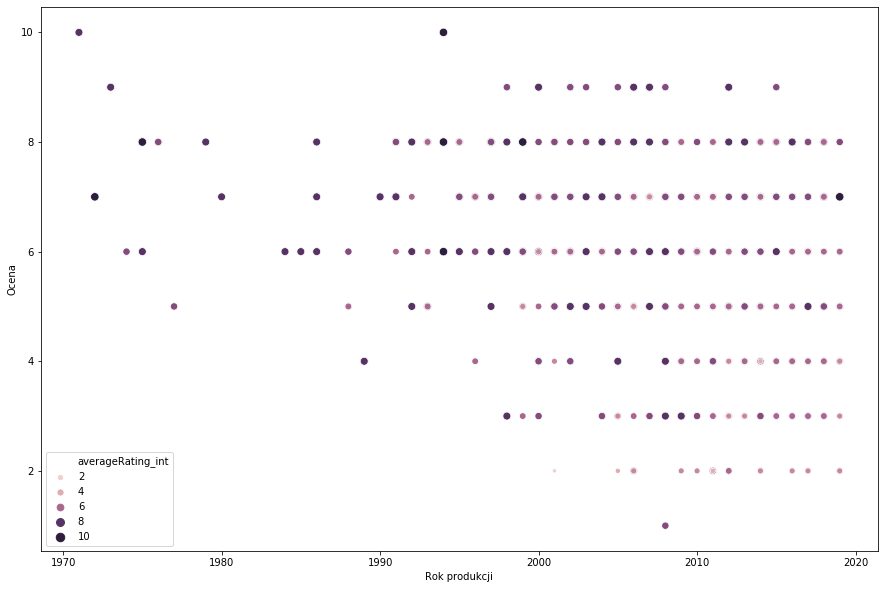

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))

sns.scatterplot(x=oceny_imdb2["Rok produkcji"], 
                y=oceny_imdb2["Ocena"],
                size = oceny_imdb2["averageRating_int"],
                hue= oceny_imdb2["averageRating_int"],
                marker="o")

In [27]:
oceny_imdb2.to_csv(r'oceny_final.csv')